Brett Cotler

21 November 2020

DATA 1010 Blog Post

### Benford's Law: Digital Analysis for Fraud Detection ###


How can we tell if a dataset is naturally-occurring? Are there any structural similarities across naturally occurring data? Intuition may suggest that a dataset drawn from a pure mathematical process may not bear any resemblence to a dataset from naturally-occurring phenomena. Furthermore, there are countless disparate natural processes that may be represented in datasets. But in reality, there is one major commonality across naturally occurring data and datasets generated from purely mathematical processes: Benford's Law. 
  






#### What is Benford's Law?

Benford's Law states that the probability distribution of the leading "significant" digit (first nonzero digit) of every entry in a dataset follows a specific logarithmic distribution:

$$ \mathbb{P}(D_1 = d_1) = \log_{10}{(1+ d_1^{-1})} \space \text{for all} \space d_1 = 1, 2, 3, ... , 9. $$

Where $d_1$ is the first significant digit, or the significand, of a given number (Berger and Hill, 2017). In other words the probability that the significand of a number in a dataset is equal to the value $d_1$ is the log (base 10) of one plus the inverse of the value $d_1$. The values for each of the 9 possible first digits are illustrated in the table and graph below. 


| Digit       | Probability |
| ----------- | ----------- |
| 1           | 0.3010      |
| 2           | 0.1761      |
| 3           | 0.1249      |
| 4           | 0.0969      |
| 5           | 0.0792      |
| 6           | 0.0669      |
| 7           | 0.0580      |
| 8           | 0.0512      |
| 9           | 0.0458      |




  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


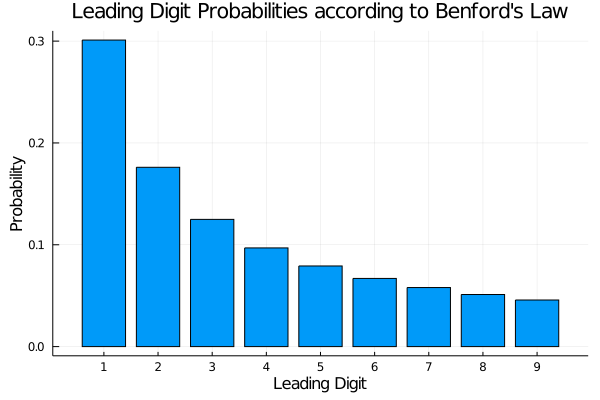

In [263]:
vals = [log(10, 1+1/d) for d in 1:9]

import Pkg; Pkg.add("Plots")
using Plots

bar(vals, xlabel = "Leading Digit", ylabel = "Probability", 
    legend = false, xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9], 
    title = "Leading Digit Probabilities according to Benford's Law")




The distribution is striking. There are almost twice as many ones as twos. There are six times as many ones as there are nines, and ones and twos make up almost 50% of the leading digits. 

Benford's Law extends beyond the first digit. It applies to all subsequent significant digits, although it becomes less pronounced in later digits. The joint distribution -- the shared probability distribution of multiple variables -- of the values of each significant digit is

$$ \mathbb{P}((D_1, D_2, ..., D_m) = (d_1, d_2, ..., d_m)) = log_{10}{(1 + (\sum_{j=1}^{m}{10^{m-j}*d_j})^{-1})} $$

Where $d_j$ is the jth significant digit of a number and m is the total number of digits (Berger and Hill, 2017). An important and surprising property of this joint distribution is that the probability of the jth digit being 4, for example, depends on the value of all previous digits. 

The joint distribution adds unnecessary confusion to the consideration of subsequent siginificant digits. To simplify things, it is better to instead consider the unconditional probability of the second significant digit by summing over all of the possible values of the significand:

$$\mathbb{P}(D_2 = k) = \sum_{j=1}^{9} log_{10}{(1 + \frac{1}{10j + k})}$$

Where k is the value of the second significant digit and j is the value of the significand (Berger and Hill 2017). Using this equation, we can determine the distribution of the second significant digit of numbers in a dataset. 

| Digit       | Probability |
| ----------- | ----------- |
| 0           | 0.1197      |
| 1           | 0.1139      |
| 2           | 0.1088      |
| 3           | 0.1043      |
| 4           | 0.1003      |
| 5           | 0.0967      |
| 6           | 0.0934      |
| 7           | 0.0904      |
| 8           | 0.0876      |
| 9           | 0.0850      |

The distribution for the second significant digit is not nearly as dramatic as the distribution for the significand, but there is still a non-negligible difference between these digits.



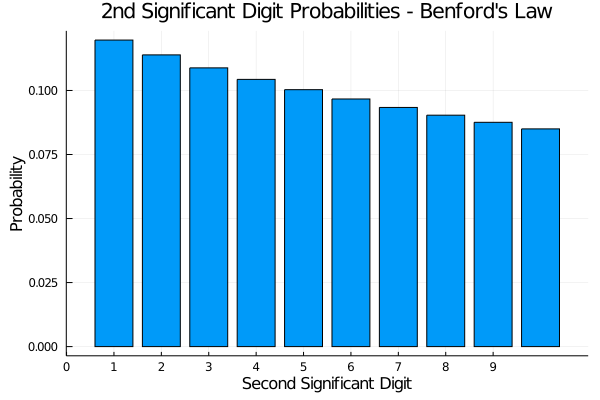

In [264]:
second_digit_fracs = []
for k in 0:9
    current = 0 
    for j in 1:9
        current += log(10,1+1/(10*j + k))
    end
    push!(second_digit_fracs, current)
end
second_digit_fracs
    
bar(second_digit_fracs, xlabel = "Second Significant Digit", ylabel = "Probability", 
    legend = false, xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
    title = "2nd Significant Digit Probabilities - Benford's Law")

#### History of Benford's Law

Benford's Law was actually first discovered by Simon Newcomb, who outlined this pattern in "Note on the Frequency of Use of the Different Digits of Natural Numbers in 1881". Newcomb noticed that logarithm tables had substantially more wear on pages containing smaller leading digits (Newcomb, 1881). Frank Benford, a physicist for the General Electric Company, made very similar observations about logarithm tables in a 1937 paper titled "The Law of Anomalous Numbers," which outlined the principle as it is understood today. Benford recognized that the leading digit of numbers from natural datsets, such as the number of words on a newspaper page, followed a logarithmic distribution more often than numbers from more formal mathematical data. He provided a variety of other examples to illustrate this pattern: population size, river area, atomic weight, addresses, cost data, etc (Benford 1937).

#### "Proving" Benford's Law

Rigorous mathematical proofs of Benford's Law do exist, see (Berger and Hill, 2017), but they are well beyond the scope of an applied introduction. In lieu of a mathematical proof, I will try to provide some general intuition about why Benford's law is true. Benford uses the example of linear frequencies to illustrate why the leading digit is skewed towards the smaller numbers as the numbers increase from 10,000 to 100,000. His plot of linear frequencies is reproduced below.




In [265]:
function benford_freqs(data)
    """function takes in a list of numbers and returns the frequencies of the leading digits as a list""" 
    freqs = zeros(9)
    digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
    for value in data
        string_value = string(value)
        for i in 1:length(string_value)
            if string_value[i] in digits
                freqs[parse(Int64, string_value[i])] += 1
                break
            end
        end
    end
    freqs ./ length(data)
end

function benford_update(lower_bound, start_val, end_val)
    data = lower_bound:start_val
    start_freqs = benford_freqs(data) 
    ones = []
    nines = []
    freqs = start_freqs .* length(data)
    digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
    for value in start_val:end_val
        string_value = string(value)
        for i in 1:length(string_value)
            if string_value[i] in digits
                freqs[parse(Int64, string_value[i])] += 1
                break
            end
        end
        push!(ones, freqs[1]/(value-lower_bound))
        push!(nines, freqs[9]/(value-lower_bound))
    end
    ones, nines
end

ones, nines = benford_update(0, 10_000, 99_999)
plot(10_000:99_999, ones, title = "fraction of ones and nines 10,000 to 100,000",
    label = "fraction of ones", xticks = 10_000:10_000:100_000, xlabel = "number", ylabel = "fraction of leading significant digits 0 to number")
plot!(10_000:99_999, nines, label = "fraction of nines")

As the natural numbers increase from 10,000 to 100,000, 1's dominate the significand frequencies, although the fraction of 1's decreases as 100,000 is approached. In contrast, the fraction of 9's is substantially smaller until 90,000 is reached. Therefore, if a dataset has an upper bound which is not a power of 10 -- which is almost always the case -- the frequencies of the significand will be skewed towards smaller digits. 

Another similar principle of the natural numbers further emphasizes this intuition. Let's start with the number 90. For the significand to change from 9 to 1, the number 90 needs to increase by $\frac{1}{9}$ or 11.11% of its value. Now let's consider the number 100. For the significant digit to change from 1 to 2, the number 100 needs to increase by a full 100% of its value (Table 2). Once again, if the numbers in a dataset have an upper bound that is not a power of 10, the first significand will be more likely to follow Benford's Law. 

| Digit Change | Percent increase  |
| -----------  | ----------- |
| 1 to 2       | 100%        |
| 2 to 3       | 50%         |
| 3 to 4       | 33.3%       |
| 4 to 5       | 25%         |
| 5 to 6       | 20%         |
| 6 to 7       | 16.6%       |
| 7 to 8       | 14.3%       |
| 8 to 9       | 12.5%       |
| 9 to 1       | 11.1%       |



#### Examples


To determine if a dataset follows Benford's Law, I wrote a simple function in julia which takes in an array of numbers and returns an array of the frequencies of the significand. 


In [262]:
function benford_freqs(data)
    """function takes in a list of numbers and returns the frequencies of the leading digits as a list""" 
    freqs = zeros(9)
    digits = string.(1:9)
    for value in data
        string_value = string(value)
        for i in 1:length(string_value)
            if string_value[i] in digits
                freqs[parse(Int64, string_value[i])] += 1
                break
            end
        end
    end
    freqs ./ length(data)
end

benford_freqs (generic function with 1 method)

There are countless examples of datasets that follow Benford's Law. One particularly interesting example comes from a famous sequence of numbers in mathematics, called the fibonacci sequence. 

The fibonacci sequence is a recursive sequence where each number is the sum of the previous two numbers in the sequence. The sequence begins with 0 and 1 and follows this recursive pattern:

$$ 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89 ... $$

If one takes a subset of the fibonacci sequence, such as the first 100 numbers, it becomes clear that the fibonacci sequence follows Benford's Law almost perfectly. The table below shows the frequency of leading digits for the first 100 fibonacci numbers:

| Digit       | Fibonacci Frequency |
| ----------- | -----------         |
| 1           | 0.3                 |
| 2           | 0.18                |
| 3           | 0.13                |
| 4           | 0.09                |
| 5           | 0.08                |
| 6           | 0.06                |
| 7           | 0.05                |
| 8           | 0.07                |
| 9           | 0.04                |


However, Benford's Law is usually exemplified by naturally occurring datasets. Something as simple as listing all of the numbers that appear in a newspaper article will likely produce a set that follows Benford's Law. As an example, I downloaded a dataset which contains the cumulative number of coronavirus cases in the United States for each day from January 21st, 2020 to November 19th, 2020. The table below shows the distribution of leading digits for cumulative case numbers in the US.


| Digit       | Cumulative Case Frequency |
| ----------- | -----------           |
| 1           | 0.2829                |
| 2           | 0.1282                |
| 3           | 0.0888                |
| 4           | 0.0789                |
| 5           | 0.1053                |
| 6           | 0.1086                |
| 7           | 0.0921                |
| 8           | 0.0691                |
| 9           | 0.0461                |
 
 
Although this distribution does not precisely fit Benford's Law, it is reasonably similar to Benford's frequencies. It is likely limited by a mere 300 data points. 


#### Why does this matter? Digital Forensic Analysis

Benford's Law is an interesting property of natural datasets, but it also has various practical applications. The most common application of Benford's Law is its use in identifying datasets that are artificially generated or manipulated. 

Stastical examination of datasets for fraud detection is called digital forensic analysis. Traditional statistical tests require taking a random sample of a dataset, but in digital forensic analysis, the entire dataset is used, because the analysis is more likely to be accurate over the entirety of the datset. It follows that digital forensic analysis is only used when there is a very large dataset. If there isn't enough data, digital forensic analysis is prone to false conclusions of guilt (Type I error). 

Digital forensic analysis also requires the removal of negative values, and some smaller positive values if they make up a sufficiently low proportion of the datset. When analysis is performed on data from a single organization, raw data values are used in favor of sums or aggregates, which may not follow Benford's Law. 

Companies may provide fraudulent data when trying to underreport their earnings to limit the taxes they must pay. When a company is reporting losses or underreporting earnnigs, fraudulent rounding would artificially increase the prevalence of nines as the first significant digit and decrease the prevalence of ones. Companies may also provide fraudulent data when trying to impress investors by overreporting their revenue. When a company is reporting increased earnings, fraudulent rounding will artificially increase the representation of one as the first significant digit and 0 as the second significant digit. 

There are unfortunately several limitations to the application of Benford's Law. Firstly, Benford's Law may not be applicable at all. Not all financial metrics conform to Benford's Law, which is why it is necessary to carefully consider what the data is meant to represent before making a potentially false accusation of fraud. For example, salary data is not likely to follow Benford's Law, as salaries are often fixed across specific departments or roles within a company. Additionally, some innocent rounding may skew the proportions of leading significant digits. 

The second major limitation is that there are ways to manipulate financial data such that Benford's Law still holds. Benford's Law has the property that it is scale-invariant. This means that the logarithmic probability distribution holds the same even if a constant scale factor is applied to a dataset. Alex Kossovsky provides an example of this in his book, "Benford's Law: Theory, The General Law Of Relative Quantities, And Forensic Fraud Detection Applications." If a company wanted to artificially inflate its income by 25% to show investors stronger earnings, it could apply a scale factor of 1.25 to all of its revenue data to ensure that its earnings reports still follow Benford's Law. 

The final limitation is that fraudulent transactions or fraudulent data are often not recorded in any way, and therefore would not be detected by forensic data analysis (Kossovosky, 2015). 


#### Application to election data

Election results also conform to Benford's Law. This occurs because population data more generally conforms to Benford's Law, and electoral results are a fraction of population data. As a result, the scale-invariance principle can be applied to suggest that election results will follow Benford's Law. 

The 2020 Presidential Election in the United States has been contested, with Donald Trump and much of the Republican Party making unfounded allegations of voter fraud and demanding recounts in various states. These claims have not held up in court, but Benford's Law can provide further confirmation that the election data is accurate. 

The availability of 2020 election data is limited, as counts and recounts in some states have only been finalized very recently. Consequently, the data presented here contains many missing values. The data was downloaded from the Kaggle Dataset titled "US Election 2020" which is sourced from Reuters. This dataset only includes the total votes from each county; the votes are not split out by candidate. Data from some counties is missing where county level data has not been reported. Any county with missing vote totals is excluded from the data visualizations included in this article. 

The graph below compares the true frequencies of Benford's law with the distribution of significands for the total votes for each county. 

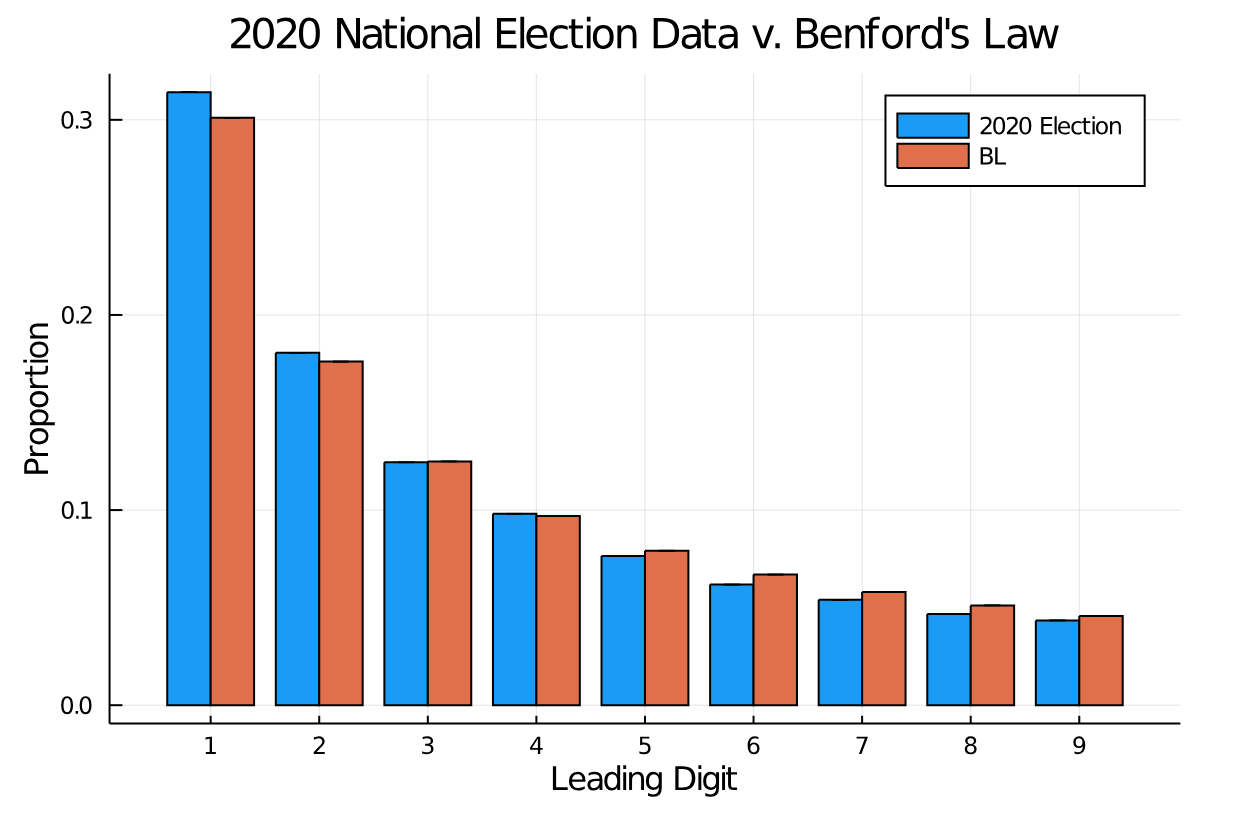

  Resolving package versions...


groups type: Array{String,1}
data type: Array{Float64,1}
digits type: Array{String,1}

No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


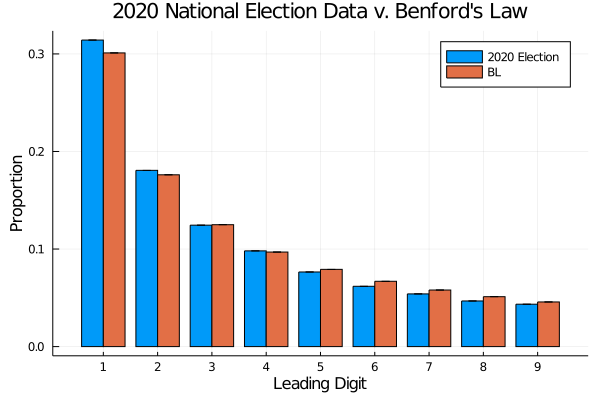

In [266]:
election_df = DataFrame(CSV.File("president_county_candidate.csv", select = [:total_votes, :state]))

filter!(row -> row.total_votes != 0, election_df)
total_votes = benford_freqs(election_df[:total_votes])

using Pkg
Pkg.add("StatsPlots")
using StatsPlots

digits = repeat(string.(1:9), outer = 2)
data = vcat(vals, total_votes)
groups = repeat(["BL", "2020 Election"], inner = 9)
print("groups type: ", typeof(groups), "\n")
print("data type: ", typeof(data), "\n")
print("digits type: ", typeof(digits))
groupedbar(digits, data, xlabel = "Leading Digit", yerr = zeros(18), ylabel = "Proportion", group = groups, 
    title = "2020 National Election Data v. Benford's Law")






It is clear from the graph that the total number of votes fits the logarithmic distribution defined by Benford's Law almost exactly. This suggests that the total vote counts were legitimate and not artificially manipulated in any way. 

This conclusion can be drawn at the state level as well. I selected three battleground states -- Wisconsin, Michigan, and Pennsylvania -- which Donald Trump won in 2016, lost in 2020, and is now contesting. The graph below compares the total vote counts in the counties of those states with the frequencies according to Benford's Law. Once again, the election data very closely fits Benford's Law. The slight discrepencies here could be a consequence of a relatively small number of counties compared to the number of counties in the entire country. 





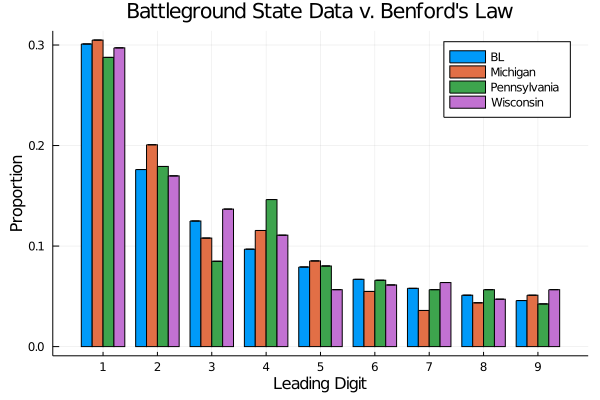

In [267]:
michigan = filter(row -> row.state == "Michigan", election_df)
pennsylvania = filter(row -> row.state == "Pennsylvania", election_df)
wisconsin = filter(row -> row.state == "Wisconsin", election_df)
georgia = filter(row -> row.state == "Georgia", election_df)
arizona = filter(row -> row.state == "Arizona", election_df)

digits = repeat(string.(1:9), outer = 4)
data = vcat(vals, benford_freqs(michigan[:total_votes]), benford_freqs(wisconsin[:total_votes]), 
    benford_freqs(pennsylvania[:total_votes]))
groups = repeat(["BL", "Michigan", "Wisconsin", "Pennsylvania"], inner = 9)
groupedbar(digits, data, xlabel = "Leading Digit", yerr = zeros(18), ylabel = "Proportion", group = groups, 
    title = "Battleground State Data v. Benford's Law")

#### Conclusion

Benford's Law is a fascinating property of a variety of mathematical and naturally-occurring datasets. Despite its abstract and technical mathematical foundations, this property follows a simple logarithmic probability distribution that can be easily visualized with a bar chart. Benford's Law has various applications in the field of digital forensic analysis of fraud detection ranging from identifying fraudulent financial data to verifying the legitimacy of election results.

#### References

Newcomb, Simon. "Note on the Frequency of Use of the Different Digits in Natural Numbers". American Journal of Mathematics, Vol. 4, No. 1. (1881), pp. 39-40.
 
Benford, Frank. "THE LAW OF ANOMALOUS NUMBERS". PROCEEDINGS OF THE AMERICAN PHILOSOPHICAL SOCIETY,
VOL. 78, NO. 4. (1938)
 
Fontes, Raphael. "US Election 2020". Kaggle (Originally from Reuters). 2020.

New York Times. "covid-19-data". Github Repository. 2020. https://github.com/nytimes/covid-19-data

Kossovsky, Alex Ely. "Benford's Law: Theory, The General Law Of Relative Quantities, And Forensic Fraud Detection Applications". New Jersey : World Scientific, [2015]

Berger, Arno and Theodore P. Hill. "A basic theory of Benford’s Law". Probability Surveys. Vol. 8 (2011) pp. 1-126. ISSN: 1549-5787. DOI: 10.1214/11-PS175



